In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut

data_dir = '../data/'
plot_dir = '../plots/'

## Learning of the 2d kite with a non-constant wind
- The aggregate state is the discretized attack angle and the angle with the relative valocity (values specified in kite.h)
- The wind velocity is based on a simple stream-function
- The initial angle with the ground, $\theta$, is constant
- The initial attack angle can be choosen constant or random
- The algortihm is a natural actor-critic with advantage parameters. It uses two power law learning rates (the one of the critic part should be much larger) having a burn-in period in which it stays constant (see the first plot of the learning rates)

In [106]:
system_name = 'kite2d_vrel'
run_name = 'ac3'

# ENVIRONMENT PARAMETERS
env_params = dict()
env_params['int_steps'] = 0.0005 # sec
env_params['ep_length'] = 50 # sec
env_params['decision_time'] = 0.02 # sec
env_params['init_theta'] = np.pi/4 # rad
env_params['init_dtheta'] = 0 # rad
env_params['init_alpha'] = 12 # index. Choosing alpha>=15 the initial attack angle is randomly chosen
# wind
env_params['wind_type'] = 1 # Type 1 for the stream-function
env_params['k_wind'] = 0.5 # 1/sec
env_params['eps_wind'] = 0.2

# ALG PARAMETERS
alg_params = dict()
alg_params['gamma'] = 1.0
alg_params['n_steps'] = 20000000
print('Learning steps: ', alg_params['n_steps']*env_params['decision_time']/env_params['int_steps'])
print('Tot "real time" of learning, in seconds: ', alg_params['n_steps']*env_params['decision_time'])
alg_params['traj_points'] = 1000
# <0 for false, >0 for true. The policy file must be in the folder
alg_params['use_init_pol_from_file'] = 1 
# <0 for false, >0 for true. The value file must be in the folder
alg_params['use_init_val_from_file'] = 1 
alg_params['init_values'] = env_params['k_wind']*20*env_params['ep_length']
# Actor learning rate
alg_params['a0'] = 0.005
alg_params['ac'] = 40000
alg_params['a_expn'] = 0.7
alg_params['a_burn'] = 20000000
# Critic learning rate
alg_params['b0'] = 0.0001
alg_params['bc'] = 40000
alg_params['b_expn'] = 0.7
alg_params['b_burn'] = 20000000

Learning steps:  800000000.0
Tot "real time" of learning, in seconds:  400000.0


In [107]:
# WRITING THE PARAMETERS
ut.write_params(env_params, data_dir+system_name+'/'+run_name + '/', "param_env.txt")
ut.write_params(alg_params, data_dir+system_name+'/'+run_name + '/', "param_alg.txt")

In [99]:
# COMPILING C++ SCRIPT
comp_list = np.array(["g++", "-o", "train.exe", "train.cpp", "../lib/nac.cpp", "../lib/utils.cpp", "../lib/wind.cpp", 
            "../lib/envs/kite.cpp", "../lib/envs/kite2d.cpp", "-std=c++17"])
comp_str = ""
for s in comp_list: comp_str+=s+" "
print('To compile from terminal: ')
print(comp_str)

To compile from terminal: 
g++ -o train.exe train.cpp ../lib/nac.cpp ../lib/utils.cpp ../lib/wind.cpp ../lib/envs/kite.cpp ../lib/envs/kite2d.cpp -std=c++17 


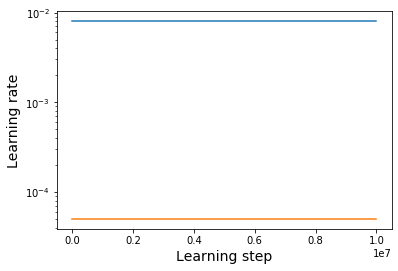

In [100]:
plt.xlabel('Learning step', fontsize=14)
plt.ylabel('Learning rate', fontsize=14)
plt.yscale('log')
xs = np.linspace(0, alg_params['n_steps'] , alg_params['traj_points'] )
crit_lr = [ut.p_law_burn(x, alg_params['a_burn'], alg_params['a_expn'], alg_params['a0'], alg_params['ac']) for x in xs]
act_lr = [ut.p_law_burn(x, alg_params['b_burn'], alg_params['b_expn'], alg_params['b0'], alg_params['bc']) for x in xs]

plt.plot(xs, crit_lr)
plt.plot(xs, act_lr)

In [101]:
import numpy as np
v_traj, s_labels = ut.read_traj(data_dir + system_name + '/' + run_name + '/value_traj.txt')
r_traj = np.loadtxt(data_dir + system_name + '/' + run_name + '/return_traj.txt', dtype='float')

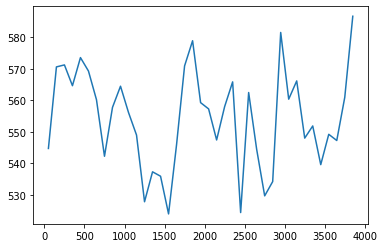

In [102]:
x, y = ut.smooth_traj(r_traj, 100)
plt.plot(x,y)

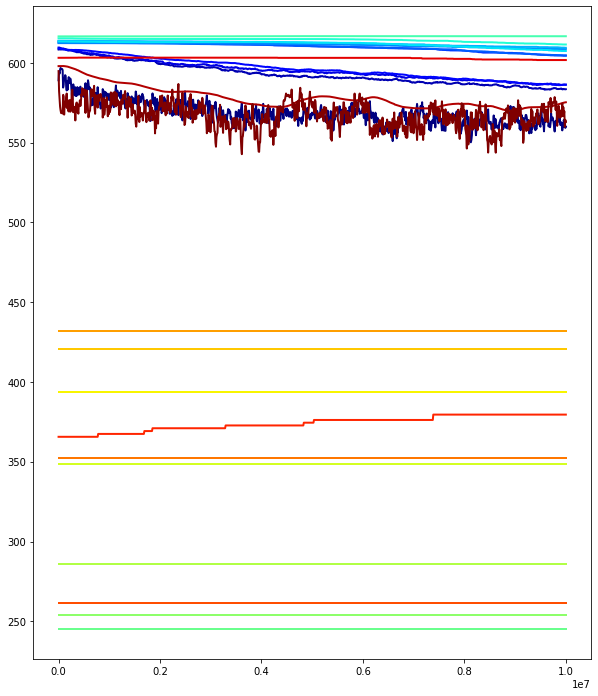

In [103]:
n_alphas=15
n_betas=24
alphas = [14]
betas = np.arange(n_betas)

colors = plt.cm.jet(np.linspace(0,1,len(alphas)*len(betas)))
plt.figure(figsize=(10,12))
count=0
for a in alphas:
    for b in betas:
        index = b+a*n_betas
        plt.plot(xs, v_traj[:,index], lw=2, label=s_labels[index], c=colors[count])
        count+=1
    
#plt.legend(loc=3)

In [104]:
p_traj, s_labels, a_labels = ut.read_policy(data_dir + system_name + '/' + run_name + '/' + "policy_traj.txt")

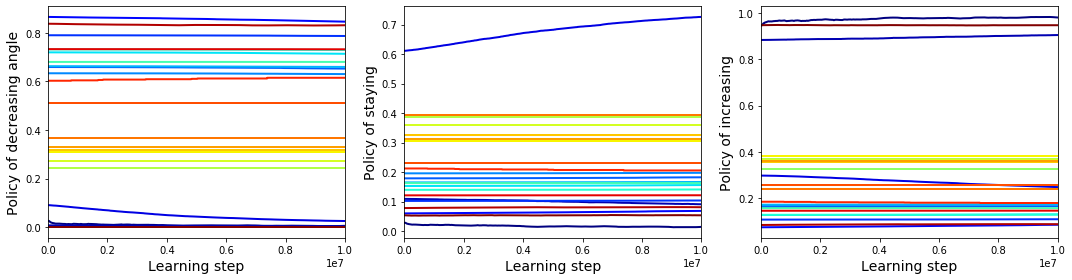

In [105]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
colors = plt.cm.jet(np.linspace(0,1,len(alphas)*len(betas)))

ax1.set_xlabel('Learning step', fontsize=14)
ax1.set_ylabel('Policy of decreasing angle', fontsize=14)
xs = np.linspace(0, alg_params['n_steps'] , alg_params['traj_points'] )
ax1.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
count=0
for a in alphas:
    for b in betas:
        index = b+a*n_betas
        ax1.plot(xs, p_traj[:,index,0], c=colors[count], label=s_labels[index], lw=2)
        count += 1
#ax1.legend()

ax2.set_xlabel('Learning step', fontsize=14)
ax2.set_ylabel('Policy of staying', fontsize=14)
ax2.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
count=0
for a in alphas:
    for b in betas:
        index = b+a*n_betas
        ax2.plot(xs, p_traj[:,index,1], c=colors[count], lw=2)
        count += 1

ax3.set_xlabel('Learning step', fontsize=14)
ax3.set_ylabel('Policy of increasing', fontsize=14)
ax3.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
count=0
for a in alphas:
    for b in betas:
        index = b+a*n_betas
        ax3.plot(xs, p_traj[:,index,2], c=colors[count], lw=2)
        count += 1
    
plt.tight_layout()